# Assignment-11
## < Text classification using neural networks >
### -20154521 Seokjun Choi

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
nltk.download('wordnet')
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split


review_data = load_files(r"/content/drive/My Drive/movie_review")
X, y = review_data.data, review_data.target

documents = []

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()
    #document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

vectorizer = CountVectorizer(max_features=2500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()

for i in range(len(X)):
  for j in range(2500):
    if X[i, j] != 0:
      X[i, j] = 1
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
num_training = X_train.shape[0]
num_testing = X_test.shape[0]

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import warnings#ignore warning messages
warnings.filterwarnings("ignore")

num_image = num_training + num_testing
list_label_training = y_train.T         
list_label_testing  = y_test.T

bias_training = np.ones((1, num_training), dtype=int)
bias_testing  = np.ones((1, num_testing), dtype=int)

image_training = np.concatenate((bias_training, X_train.T), axis=0)
image_testing  = np.concatenate((bias_testing, X_test.T), axis=0)

In [5]:
def sigmoid(matrix):
    return 1 / (1 + np.exp(-matrix))

def loss(h, label, m):
    return -(np.sum((label*np.log(h))+(1-label)*np.log(1-h)))/m

def forward_prop(u, v, w, x, m):
    bias = np.ones((1,m))
    
    y_ = u.dot(x)
    y  = sigmoid(y_)
    y  = np.concatenate((bias, y), axis=0)

    z_ = v.dot(y)
    z  = sigmoid(z_)
    z  = np.concatenate((bias, z), axis=0)
    
    h_ = w.dot(z)
    h  = sigmoid(h_)
    
    return y, z, h

In [6]:
def delta_4(h, label):
    return h-label

def delta_3(d4, w, z):
    diff1 = (w.T).dot(d4)
    diff2 = z * (1 - z)
    return diff1*diff2

def delta_2(d3, v, y):
    bias = np.ones((1, 197))
    v = np.concatenate((bias, v), axis=0)
    diff1 = (v.T).dot(d3)
    diff2 = y * (1 - y)
    return diff1*diff2

def partial_w(d4, z, m):
    return (d4.dot(z.T))/m
    
def partial_v(d3, y, m):
    return (d3.dot(y.T))/m

def partial_u(d2, x, m):
    return (d2.dot(x.T))/m

In [7]:
def predict(h, m): #return predicted label list
    
    pred_list = np.empty(m, dtype=int)
    for i in range(m):
        max = 0
        idx = 0
        if h[0,i] > 0.5:
          pred_list[i] = 1
        else:
          pred_list[i] = 0
        
    return pred_list

def getAccuracy(h, label, m): #return accuracy value
    
    correct = 0

    pred = predict(h, m)
    for i in range(m):
        if pred[i] == label[i]:
            correct += 1
    accuracy = correct / m
    
    return accuracy

In [8]:
#assign random values to weights(u, v, w)
bias_1 = np.zeros((196, 1), dtype=float)
bias_2 = np.zeros((49, 1), dtype=float)
bias_3 = np.zeros((1, 1), dtype=float)

u = np.random.randn(196, 2500)/np.sqrt((2500+196)/2)    
v = np.random.randn(49, 196)/np.sqrt((196+49)/2)
w = np.random.randn(1, 49)/np.sqrt((1+49)/2)

u = np.concatenate((bias_1, u), axis=1)
v = np.concatenate((bias_2, v), axis=1)
w = np.concatenate((bias_3, w), axis=1)

#set parameters
learning_rate = 2 #1.85

lamda = 0 #0.001
num_param = 305850

t         = 0
iteration = list()

temp_loss = 0 
temp_loss_test = 0
train_loss_list = list()
test_loss_list  = list()

training_accuracy_list = list()
testing_accuracy_list = list()

In [9]:
#while True:
for it in range(1000):
    #back propagation
    
    #make training loss list
    (y, z, h) = forward_prop(u, v, w, image_training, num_training)
    if t>1 and abs(temp_loss - loss(h, y_train.T, num_training)) <= 0:
        break
    temp_loss = loss(h, y_train.T, num_training)
    train_loss_list.append(temp_loss)
    iteration.append(t)

    #make testing loss list
    (y_test2, z_test, h_test) = forward_prop(u, v, w, image_testing, num_testing)
    temp_loss_test = loss(h_test, y_test.T, num_testing)
    test_loss_list.append(temp_loss_test)
    
    d4 = delta_4(h, y_train.T)
    d3 = delta_3(d4, w, z)
    d2 = delta_2(d3, v, y)
    
    p_w = partial_w(d4, z, num_training)
    temp_p_v = partial_v(d3, y, num_training)
    temp_p_u = partial_u(d2, image_training, num_training)
    
    p_v = temp_p_v[1:50, :]
    p_u = temp_p_u[1:197, :]
        
    w = (1 - (learning_rate * lamda)/num_param) * w - learning_rate * p_w
    v = (1 - (learning_rate * lamda)/num_param) * v - learning_rate * p_v
    u = (1 - (learning_rate * lamda)/num_param) * u - learning_rate * p_u
    
    #make accuracy list
    training_accuracy = getAccuracy(h, list_label_training, num_training) * 100
    training_accuracy_list.append(training_accuracy)
    
    testing_accuracy = getAccuracy(h_test, list_label_testing, num_testing) * 100
    testing_accuracy_list.append(testing_accuracy)
    
    print(t, temp_loss, '\n')
    t += 1

0 0.7080503718199207 

1 1.7088894603245683 

2 5.244308538141304 

3 0.7260317667910914 

4 0.6937633230480198 

5 0.6936533533627306 

6 0.693606001900109 

7 0.693559467753927 

8 0.6935135607322851 

9 0.6934680944660618 

10 0.6934228819562552 

11 0.6933777329936303 

12 0.6933324514018463 

13 0.6932868320217599 

14 0.6932406573423983 

15 0.6931936936665588 

16 0.6931456866760944 

17 0.6930963562325079 

18 0.6930453902110997 

19 0.6929924371199673 

20 0.6929370971970011 

21 0.6928789116072844 

22 0.6928173492795108 

23 0.6927517908249705 

24 0.6926815088825828 

25 0.6926056441433119 

26 0.6925231762577635 

27 0.6924328888796298 

28 0.69233332834779 

29 0.6922227561338433 

30 0.6920990964506387 

31 0.6919598827172968 

32 0.6918022103705748 

33 0.6916227091490449 

34 0.69141755516465 

35 0.6911825498207135 

36 0.6909132936649681 

37 0.6906054690092096 

38 0.6902552044314431 

39 0.6898594254429062 

40 0.689416025269561 

41 0.6889236796639868 

42 0.68838

### 0. Optimization
- The loss function $J(\theta)$.
  - $J(\theta)$ = $\frac{-1}{m}\sum_{i=1}^{m}(l^{(i)}log(\sigma(h^{(i)}))$ + $(1 - l^{(i)})log(1 -\sigma(h^{(i)}))) + \frac{\lambda}{2m}\sum\theta^{2}$.

- Weights  $\theta = (u, v, w)$. 

- $u$ = 196X2500. $v$ = 49X197. $w$ = 1X50.

- Lambda for regularization term = 0

- Learning rate = 2

- Input data $x$.

- Predicted label $h$.

- $h = \sigma(w\sigma(v \sigma(u x))$.

- '$\sigma(z)$' is sigmoid for activation function.
  - $\sigma(z) = \frac{1}{1+e^{(-z)}}$.

- Back-propagation using partial derivatives.
  - $\delta^{(4)} = h - label$
  - $\delta^{(l)} = (\theta^{(l)})^{T}\delta^{l+1}.*(a^{(l)}.*(1-a^{(l)}))$
  - $\frac{\partial}{\partial\theta^{(l)}}J(\theta) = \frac{1}{m}\delta^{(l+1)}(a^{(l)})^{T} + \frac{\lambda}{m}\theta$.
  - $\theta^{(l)}_{(t+1)}$ := $(1 - \alpha\frac{\lambda}{m})\theta^{(l)}_{(t)}$ - $\alpha\frac{\partial}{\partial\theta^{(l)}}J(\theta)$.

### 1. Plotting the loss curve
    - Load data from 'movie_review' file.
    - Make data sets for each category.
    - Define functions for forward-propagation & back-propagation.
    - Oprimization u, v, w by gradient descent algorithm.
    - Plot the training & testing loss at every iteration of gradient descent

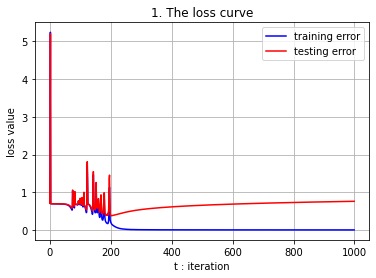

In [10]:
plt.plot(iteration, train_loss_list, c = 'blue')
plt.plot(iteration, test_loss_list, c = 'red')
plt.legend(['training error', 'testing error'])
plt.xlabel('t : iteration')
plt.ylabel('loss value')
plt.title('1. The loss curve')
plt.grid()
plt.show()

### 2. Plotting the accuracy curve
    - Get all training & testing accuracy(%) at every iteration by using defined function.

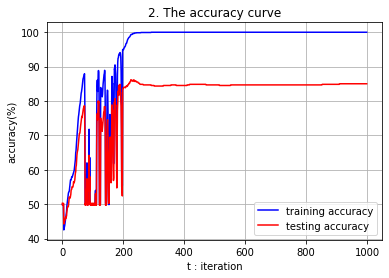

In [11]:
plt.plot(iteration, training_accuracy_list, c = 'blue')
plt.plot(iteration, testing_accuracy_list, c = 'red')
plt.legend(['training accuracy', 'testing accuracy'])
plt.xlabel('t : iteration')
plt.ylabel('accuracy(%)')
plt.title('2. The accuracy curve')
plt.grid()
plt.show()

### 3. Plot the quantitative results
    - Print the confusion_matrix based on the training data.
    - Print the classification_report based on the training data.
    - Print the accuracy_score based on the training data.


    - Print the confusion_matrix based on the testing data.
    - Print the classification_report based on the testing data.
    - Print the accuracy_score based on the testing data.

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(list_label_training,h[0].round()))
print(classification_report(list_label_training,h[0].round()))
print(accuracy_score(list_label_training,h[0].round()))

print(confusion_matrix(list_label_testing,h_test[0].round()))
print(classification_report(list_label_testing,h_test[0].round()))
print(accuracy_score(list_label_testing,h_test[0].round()))

[[699   0]
 [  0 702]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       699
           1       1.00      1.00      1.00       702

    accuracy                           1.00      1401
   macro avg       1.00      1.00      1.00      1401
weighted avg       1.00      1.00      1.00      1401

1.0
[[253  49]
 [ 41 258]]
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       302
           1       0.84      0.86      0.85       299

    accuracy                           0.85       601
   macro avg       0.85      0.85      0.85       601
weighted avg       0.85      0.85      0.85       601

0.8502495840266223


### 4. Testing Accuracy


In [13]:
print('4. The accuracy value')
print('The final training accuracy : ', training_accuracy, '%')
print('The final testing accuracy : ', testing_accuracy, '%')

3. The accuracy value
The final training accuracy :  100.0 %
The final testing accuracy :  85.02495840266224 %
